In [1]:
from kuramoto.SDL_SVP import SDL_SVP
from kuramoto.SDL_BCD import SDL_BCD
from kuramoto.SNMF import SNMF
from kuramoto.LMF import LMF
from kuramoto.nmf import *

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [2]:
sampling_alg = 'pivot'

ntwk = 'Caltech36' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 769
num edges in G 33312


num of subgraphs induced on k-paths: 900
X.shape (2500, 900)


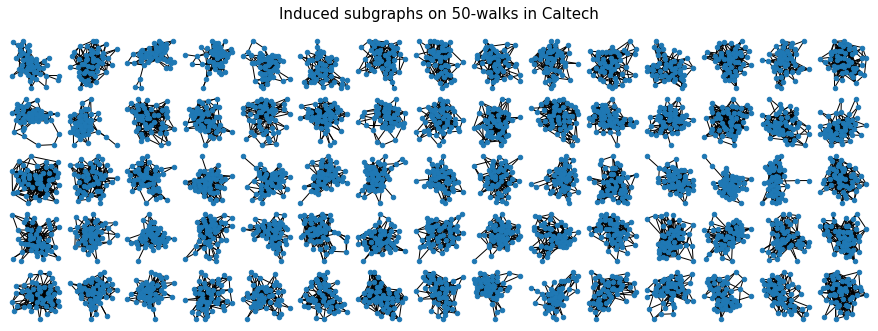

In [3]:
X, embs = G.get_patches(k=k, sample_size=900, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 900


In [13]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 2.6

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,False
1,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,False
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,False
896,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,True
897,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,True
898,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,False


In [14]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.49333333333333335


In [15]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size=0.33)

## SNMF

In [17]:
iteration1 = 200 # Iteration for logistic training
xi_list = [0, 0.1, 1, 5, 10] # Trade-off parameters
beta = 1
iter_avg = 4
r = 16

SNMF_AUC_array = np.zeros(shape=[iter_avg, len(xi_list)]) 

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        SNMF_class_new = SNMF(X=[X_train.T, Y_train.T],
                              X_test=[X_test.T, Y_test.T],
                              n_components=r,
                              xi=xi,
                              L1_reg = [0,0,0],
                              L2_reg = [0,0,0],
                              nonnegativity=[True,True,False],
                              full_dim=False)

        results_dict_new_snmf_cv = SNMF_class_new.train_logistic(iter=iteration1, 
                                                                 subsample_size=None, 
                                                                 beta = beta,
                                                                 search_radius_const=1,
                                                                 update_nuance_param=False,
                                                                 if_compute_recons_error=False, 
                                                                 if_validate=False)

        SNMF_AUC_array[i, j] = results_dict_new_snmf_cv.get('Accuracy')

xi_SNMF = xi_list[np.argmax(np.sum(SNMF_AUC_array, 0))]

initial loading beta [[-0.16951434  0.61377437  0.38212864 -0.26065105 -0.54608018  0.02472276
  -0.88312396  0.75428504 -0.54124223  0.75008544 -0.03521712  0.44290954
  -0.30939989  0.84261252  0.442962    0.58205759 -0.12427883]]


100%|█████████████████████████████████████████| 200/200 [00:14<00:00, 14.13it/s]


initial loading beta [[ 0.23769651  0.88010417  0.90570412  0.39323971 -0.01451776 -0.46877297
  -0.35271257 -0.18263781 -0.50552992 -0.43254143  0.25875042  0.75688365
   0.49085617  0.87088784 -0.95828603  0.5062252   0.64016597]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.82it/s]


initial loading beta [[ 0.26990885 -0.47700728  0.69090287 -0.16632334 -0.19831731  0.9881033
  -0.15846264 -0.83357952  0.74943151 -0.19973584 -0.23355679  0.29809602
  -0.64473322 -0.31567541 -0.78275363 -0.66413561  0.57714474]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.67it/s]


initial loading beta [[ 0.68735315  0.5350619   0.31383744 -0.53441671 -0.36548912 -0.23628022
   0.09505807 -0.59778253 -0.07829595 -0.97742871  0.62304649  0.52444928
  -0.93446993  0.68642643 -0.73260172  0.76940288  0.54374994]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.01it/s]


initial loading beta [[ 0.89518926 -0.0531551  -0.97587216 -0.35394751  0.36431655  0.11365766
  -0.36660155  0.19392093  0.3145592  -0.16506276 -0.69055285  0.66175204
  -0.92199091 -0.35619385  0.12892896 -0.33497724  0.67438975]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.47it/s]


initial loading beta [[ 0.96369338 -0.15813916  0.23020789 -0.70815066 -0.16340459  0.05529622
   0.63641906 -0.54349993 -0.43479459  0.36583538 -0.01402048  0.19652089
   0.31166307 -0.6571479  -0.31017753  0.96657659  0.34442667]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.77it/s]


initial loading beta [[-0.72275689 -0.00980312 -0.04279054 -0.44501771 -0.80990023  0.02934874
  -0.64001487 -0.20684362 -0.25313058  0.75157627 -0.51418396  0.14422183
  -0.73706432  0.65784968  0.79210025  0.69917059  0.21913434]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.37it/s]


initial loading beta [[-0.52833097 -0.5817279  -0.4218085   0.32541112  0.83720375  0.99777467
  -0.87964922  0.50445696  0.30713966 -0.79127747 -0.90858709  0.40406426
  -0.2460841   0.26199325  0.66448009  0.12325769 -0.026679  ]]


100%|█████████████████████████████████████████| 200/200 [00:14<00:00, 14.01it/s]


initial loading beta [[-0.1547875  -0.10619854  0.99134065  0.40696849  0.33239177  0.62138891
   0.37719097  0.20142403 -0.38086402  0.37560561 -0.26532069  0.94400596
  -0.01635401 -0.9370371   0.85668821 -0.29316824 -0.0697106 ]]


100%|█████████████████████████████████████████| 200/200 [00:15<00:00, 13.23it/s]


initial loading beta [[ 0.14221255  0.59815565 -0.24874421  0.60911049  0.95901993  0.23255664
  -0.43527891 -0.0982829   0.9351125  -0.6259214   0.13673577  0.83017281
   0.02488647 -0.94788313 -0.64774281 -0.60217925  0.17857374]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.07it/s]


initial loading beta [[-0.18742437 -0.94437687 -0.61549521  0.32346251 -0.97427689 -0.59628389
  -0.21962169 -0.89290326  0.84696663  0.02746775  0.21599238 -0.27902106
  -0.99531743 -0.08301849 -0.76292592  0.37263739  0.48240265]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.46it/s]


initial loading beta [[-0.46689049  0.98243846 -0.91646107  0.51460717  0.05037385 -0.09587313
   0.03855079 -0.34369894  0.97030205 -0.66733367 -0.89744014 -0.80539912
   0.11157947 -0.6944954  -0.98889777 -0.55166921 -0.6463241 ]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.85it/s]


initial loading beta [[ 0.10640585 -0.02220363 -0.29466817 -0.28348471 -0.62034886 -0.30857102
  -0.78492942 -0.04198033 -0.10610635 -0.8913078  -0.81783719  0.21836657
  -0.97527133  0.13476377  0.91367404  0.43227906  0.28356713]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.30it/s]


initial loading beta [[-0.71845489 -0.69762528  0.64252223 -0.46590687  0.45015887  0.95871265
  -0.7247616  -0.16545001 -0.0582775  -0.8100324   0.8649286  -0.87788015
   0.65986728 -0.21940034 -0.91091353 -0.18113321  0.03697444]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.99it/s]


initial loading beta [[ 0.98410044  0.59481512 -0.80309609 -0.00634282 -0.19226686 -0.79006919
  -0.12016861 -0.68141017  0.01639556  0.9921835  -0.86871638  0.17019354
   0.01674359 -0.98469313  0.43159171 -0.61753464 -0.39981951]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.13it/s]


initial loading beta [[-0.42710319  0.25453704 -0.19797346  0.61404248 -0.31383409 -0.60483471
   0.80227948  0.43625429  0.01229692 -0.42996255  0.34301932 -0.59257728
  -0.63001625  0.48625048 -0.49674774  0.05637008  0.81316932]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.76it/s]


initial loading beta [[-0.89377925  0.46116978  0.00998996 -0.99768915 -0.94462888  0.89784632
   0.55972374  0.33709162 -0.81590385 -0.23607238  0.70632808  0.97724974
  -0.7106049   0.30669041 -0.12581302  0.64022489  0.28012885]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 15.42it/s]


initial loading beta [[-0.05964077 -0.45744541 -0.0907316  -0.20101328  0.39899042  0.63422388
  -0.28681364  0.55167199  0.77134598  0.6857442   0.39761305  0.48306395
   0.82672515 -0.3110501  -0.95329031 -0.92882628  0.04371871]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 14.72it/s]


initial loading beta [[ 0.03983329  0.7386289   0.66899728 -0.92079222  0.90490256  0.36173329
  -0.91663348  0.16315831  0.5325354   0.48032133  0.99461024  0.95508041
  -0.13222966  0.35608723  0.73491478  0.14398825  0.08809215]]


100%|█████████████████████████████████████████| 200/200 [00:13<00:00, 15.16it/s]


initial loading beta [[ 0.69218086 -0.51717287  0.40727675  0.37541821 -0.44949166  0.33312879
  -0.42689879  0.63670547  0.55609428  0.59455385 -0.20840238  0.86691514
  -0.19121805  0.89400998  0.57566829 -0.73442511  0.52169301]]


100%|█████████████████████████████████████████| 200/200 [00:12<00:00, 15.42it/s]


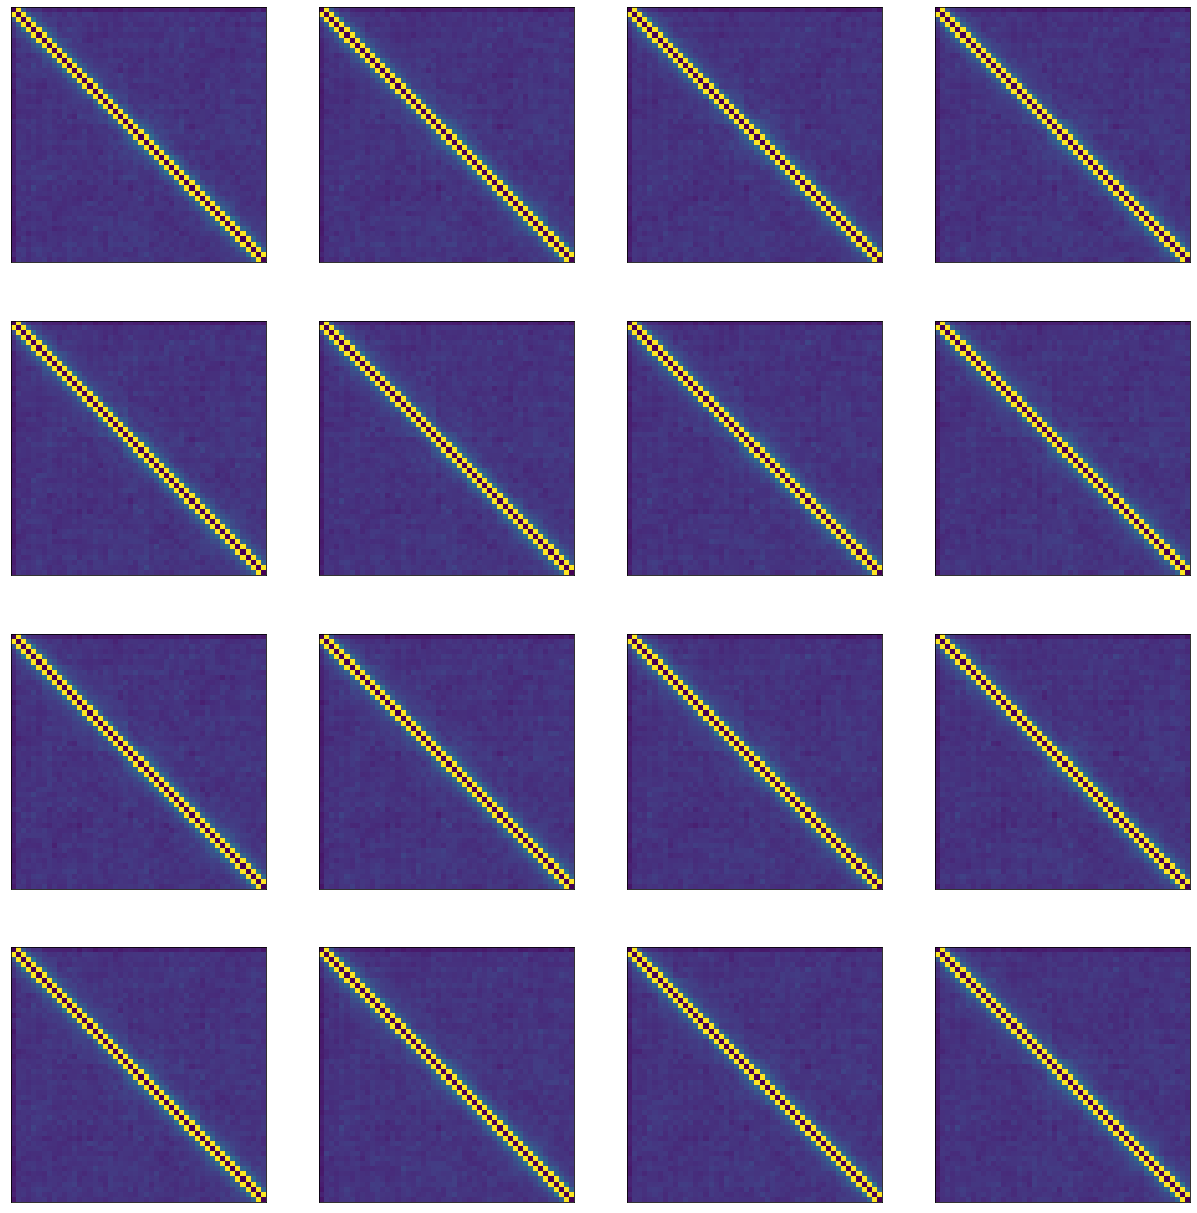

In [23]:
W = results_dict_new_snmf_cv.get('loading')[0]
display_dictionary(save_name=save_folder+'Caltech_SNMF_Dictionaries', W=W, figsize=[20,20])

## LMF

In [19]:
iteration = 200
results_dict_list = []
xi_list = [0, 0.1, 1, 10]
beta_list = [1, None]
iter_avg = 4
r = 16

LMF_AUC_array_naive = np.zeros(shape=[iter_avg, len(xi_list)])
LMF_AUC_array_exhaustive = np.zeros(shape=[iter_avg, len(xi_list)])

for beta in beta_list:
    for j in range(len(xi_list)):
        xi = xi_list[j]
        for i in range(iter_avg):
            LMF_class_new = LMF(X = [X_train.T, Y_train.T],
                            X_test = [X_test.T, Y_test.T],
                            n_components = r,
                            xi = xi,
                            L1_reg = [0,0,0],
                            L2_reg = [0,0,1],
                            nonnegativity=[True,True,False],
                            full_dim=False)

            results_dict_new = LMF_class_new.train_logistic(iter=iteration, subsample_size=None, 
                                                    beta = beta, 
                                                    search_radius_const=1000,
                                                    fine_tune_beta=True,
                                                    update_nuance_param=False,
                                                    if_compute_recons_error=False, if_validate=False)

            results_dict_new.update({'method': 'SDL-feat (naive)'})
            results_dict_new.update({'beta': beta})
            results_dict_new.update({'Accuracy': results_dict_new.get('Accuracy (naive)')})
            results_dict_new.update({'F_score': results_dict_new.get('F_score (naive)')})
            results_dict_list.append(results_dict_new.copy())

            results_dict_new1 = results_dict_new.copy()
            results_dict_new1.update({'method': 'SDL-feat (exhaustive)'})
            results_dict_new1.update({'beta': beta})
            results_dict_new1.update({'Accuracy': results_dict_new1.get('Accuracy (exhaustive)')})
            results_dict_new1.update({'F_score': results_dict_new.get('F_score (exhaustive)')})
            results_dict_list.append(results_dict_new1.copy())

            LMF_AUC_array_naive[i,j] = results_dict_new.get('Accuracy (naive)') 
            LMF_AUC_array_exhaustive[i,j] = results_dict_new.get('Accuracy (exhaustive)')

initial loading beta [[0.45041371 0.73682246 0.74304878 0.51504073 0.99364263 0.00378209
  0.18091034 0.11631563 0.13806238 0.37889481 0.01580882 0.02490975
  0.30717274 0.17793856 0.9871808  0.4744221  0.96102693]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.38it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.52, 0.532, 0.512]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.59it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.939, 0.527, 0.485, 0.554]
initial loading beta [[0.86668558 0.56855975 0.64786093 0.77357229 0.7514736  0.8907342
  0.99937444 0.25165494 0.51238996 0.96157576 0.09610456 0.59658741
  0.21129287 0.49403693 0.97265442 0.63453206 0.56781442]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 42.24it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.08, 0.537, 0.522, 0.486]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.19it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.006, 0.536, 0.519, 0.302]
initial loading beta [[0.49953252 0.98337343 0.31024985 0.60733773 0.06991022 0.12035285
  0.87515035 0.21356312 0.42328    0.47242026 0.62555071 0.14182778
  0.6565873  0.80420621 0.20043475 0.8802195  0.88972205]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.23it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.05, 0.521, 0.535, 0.511]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.32it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.007, 0.442, 0.455, 0.257]
initial loading beta [[0.69983587 0.41869176 0.86122632 0.4362927  0.01347603 0.97663145
  0.95951545 0.92201333 0.54621834 0.43903926 0.52572528 0.61784566
  0.65723963 0.4157582  0.1572095  0.94927097 0.35694799]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 57.99it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.002, 0.534, 0.508, 0.497]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.19it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.026, 0.49, 0.508, 0.421]
initial loading beta [[0.39856227 0.38138503 0.50407109 0.9051382  0.84509764 0.75169861
  0.61038752 0.44312352 0.55863096 0.8187788  0.8341505  0.27604738
  0.73527067 0.62968575 0.03692629 0.89116357 0.39932069]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 54.51it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.999, 0.535, 0.566, 0.46]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.56it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.542, 0.549, 0.481]
initial loading beta [[0.60164411 0.30548949 0.51570726 0.40905154 0.22016413 0.11247709
  0.94068562 0.7809507  0.32318503 0.60188291 0.86017412 0.61430931
  0.72791595 0.69040641 0.81344148 0.09668541 0.62815099]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 52.88it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.292, 0.501, 0.508, 0.421]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:09<00:00, 29.71it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.991, 0.557, 0.542, 0.496]
initial loading beta [[0.04657621 0.98866868 0.75621448 0.07350167 0.77375835 0.5028669
  0.61675205 0.21916794 0.56316123 0.25428415 0.62774317 0.31284887
  0.51179055 0.94487556 0.17876716 0.71064322 0.62691072]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 55.15it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.564, 0.566, 0.502]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.16it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.552, 0.519, 0.509]
initial loading beta [[0.40029949 0.48537251 0.90026309 0.78520485 0.97597844 0.78448575
  0.68293702 0.35785385 0.90575482 0.38179361 0.13491488 0.37147191
  0.16802723 0.10178762 0.73358245 0.6635705  0.79223153]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 41.00it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.533, 0.532, 0.479]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.48it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.005, 0.506, 0.495, 0.464]
initial loading beta [[0.16295989 0.16346642 0.84004374 0.52651106 0.42674098 0.4107961
  0.93587886 0.60610521 0.51027352 0.79194208 0.68271387 0.64927949
  0.70001652 0.46906985 0.32630107 0.96693538 0.40194161]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 39.85it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.004, 0.49, 0.455, 0.503]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.46it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.489, 0.475, 0.585]
initial loading beta [[0.33976235 0.03672539 0.25142465 0.61280809 0.92967286 0.2861201
  0.25066137 0.51687997 0.65461072 0.01383539 0.33514875 0.56339945
  0.85716916 0.34591576 0.73575371 0.42131982 0.7803787 ]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 38.97it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.506, 0.468, 0.451]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.31it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.491, 0.461, 0.556]
initial loading beta [[0.63273297 0.70836325 0.95692701 0.73959929 0.38815875 0.72392379
  0.54886953 0.82437717 0.9736207  0.07395912 0.51737874 0.56021388
  0.74557014 0.17458796 0.07959904 0.37506802 0.8009669 ]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 42.34it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.979, 0.57, 0.572, 0.498]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.23it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.593, 0.569, 0.576]
initial loading beta [[0.76167378 0.91346477 0.50790061 0.24367945 0.99473956 0.04413027
  0.82202201 0.04473778 0.38815611 0.47177733 0.24631337 0.71460386
  0.84514128 0.73783048 0.39616401 0.02995662 0.84921654]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 38.13it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.99, 0.524, 0.505, 0.527]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.17it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.78, 0.54, 0.535, 0.496]
initial loading beta [[0.77962861 0.39698493 0.50457387 0.19919475 0.16844684 0.78316496
  0.75906998 0.42146216 0.19758415 0.8740084  0.59667471 0.52382342
  0.16276415 0.92928068 0.47309487 0.4554349  0.80132493]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 49.53it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.198, 0.579, 0.562, 0.476]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.38it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.563, 0.549, 0.455]
initial loading beta [[0.03620355 0.1258965  0.56898074 0.42840956 0.78037816 0.28985989
  0.83267932 0.11402205 0.08735579 0.92909313 0.04208959 0.43970261
  0.06973735 0.29687211 0.2812647  0.08334464 0.32187621]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.73it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.46, 0.584, 0.539, 0.407]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.26it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.589, 0.532, 0.483]
initial loading beta [[0.58432757 0.25715838 0.33408113 0.50875175 0.55658681 0.47234168
  0.38139823 0.3625083  0.92828275 0.75228757 0.88805751 0.55795362
  0.85251203 0.6921523  0.9267995  0.64520768 0.79115474]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.00it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.587, 0.565, 0.545, 0.372]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.21it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.176, 0.565, 0.522, 0.466]
initial loading beta [[0.46054765 0.99923126 0.69812665 0.21101368 0.58907393 0.00668736
  0.27823039 0.91081435 0.06855173 0.08882143 0.16680352 0.14114848
  0.64440602 0.78757035 0.72552731 0.42934993 0.89396527]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 50.96it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.475, 0.583, 0.572, 0.524]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.33it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.578, 0.562, 0.504]
initial loading beta [[0.31934763 0.24164302 0.11341727 0.9451603  0.92125146 0.94682268
  0.29835278 0.99868899 0.0647292  0.72995109 0.24477477 0.92461964
  0.45532876 0.27694832 0.05136852 0.1535971  0.41372378]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 64.82it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.475, 0.478, 0.406]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.82it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.986, 0.448, 0.438, 0.532]
initial loading beta [[0.79485585 0.24764348 0.06796678 0.8844984  0.29449994 0.94639659
  0.48643187 0.12412188 0.85083827 0.60242134 0.11147652 0.85169404
  0.16317564 0.15902634 0.06260529 0.64086239 0.2331521 ]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 56.52it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.483, 0.529, 0.397]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.14it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.302, 0.49, 0.522, 0.377]
initial loading beta [[0.99004409 0.22394213 0.53709653 0.20408886 0.32259293 0.93579358
  0.8856406  0.09780823 0.89981247 0.17396006 0.09076136 0.26071152
  0.69524145 0.00308715 0.98940209 0.12790809 0.19911295]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.65it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.519, 0.488, 0.522]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.75it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.989, 0.498, 0.478, 0.556]
initial loading beta [[0.86989903 0.48175794 0.27690018 0.17049264 0.19425916 0.50876737
  0.17763597 0.08928448 0.6722843  0.3641362  0.08373358 0.82438008
  0.56743999 0.00768521 0.93006488 0.08985562 0.15037703]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.07it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.504, 0.532, 0.398]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.11it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.01, 0.583, 0.562, 0.5]
initial loading beta [[0.00506282 0.93098754 0.14629927 0.76564997 0.40124376 0.69756492
  0.14262788 0.48257663 0.53898289 0.26700969 0.15930636 0.91170964
  0.25280856 0.86265919 0.77766309 0.92840736 0.06448896]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 60.03it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.991, 0.528, 0.525, 0.487]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.33it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.043, 0.491, 0.505, 0.477]
initial loading beta [[0.37086504 0.87969388 0.482603   0.80186583 0.98108349 0.43271112
  0.51725927 0.5973863  0.05720531 0.51108057 0.22515629 0.3433792
  0.11931131 0.19515764 0.55648177 0.7106651  0.15792559]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.97it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.494, 0.542, 0.46]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.54it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.968, 0.53, 0.492, 0.541]
initial loading beta [[0.6108052  0.32638954 0.29267319 0.0137176  0.35233287 0.27726409
  0.10618672 0.13769925 0.79953072 0.14733509 0.18680304 0.35432872
  0.3363187  0.79806666 0.01227779 0.95257948 0.77019615]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 61.35it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [1.0, 0.518, 0.508, 0.475]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.23it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.002, 0.462, 0.421, 0.438]
initial loading beta [[0.7677785  0.40265743 0.96450945 0.74668763 0.38883424 0.24434631
  0.33893384 0.909454   0.8528894  0.48363194 0.959757   0.57631164
  0.50452598 0.79173677 0.95016901 0.29082983 0.7098523 ]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 58.02it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.516, 0.508, 0.451]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.09it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.025, 0.497, 0.488, 0.42]
initial loading beta [[0.68092755 0.6218573  0.55622552 0.84654758 0.62207848 0.8699782
  0.57032269 0.11153575 0.70314895 0.14058861 0.81293543 0.69188367
  0.39068781 0.49278687 0.63188734 0.49297001 0.46268589]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 32.34it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.995, 0.554, 0.525, 0.538]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.13it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.837, 0.568, 0.539, 0.571]
initial loading beta [[0.20654358 0.21750728 0.57206266 0.43506954 0.28140228 0.18091761
  0.3030751  0.19110276 0.49590229 0.70420552 0.73145178 0.19663569
  0.53742304 0.20751717 0.68908279 0.45455335 0.98040327]]


100%|█████████████████████████████████████████| 200/200 [00:06<00:00, 33.21it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.447, 0.481, 0.542]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.64it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.152, 0.459, 0.502, 0.253]
initial loading beta [[0.44518836 0.61284711 0.88139678 0.57227399 0.45758724 0.49269101
  0.43074395 0.65033265 0.84389635 0.53982226 0.55772442 0.97670167
  0.18726575 0.33375954 0.7206168  0.54800997 0.62979166]]


100%|█████████████████████████████████████████| 200/200 [00:05<00:00, 38.21it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.462, 0.508, 0.529, 0.53]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.27it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.199, 0.47, 0.444, 0.519]
initial loading beta [[0.63764129 0.60516415 0.54926103 0.09928733 0.6891837  0.90004185
  0.61911622 0.69441293 0.84477574 0.88189815 0.24024158 0.80381175
  0.90360998 0.83425629 0.88174328 0.57837408 0.73421811]]


100%|█████████████████████████████████████████| 200/200 [00:04<00:00, 41.05it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.548, 0.532, 0.451]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 28.90it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.563, 0.545, 0.341]
initial loading beta [[0.64455814 0.77854605 0.74427762 0.96264178 0.45669501 0.44408621
  0.8375382  0.76241194 0.4970475  0.78951691 0.98820963 0.48208029
  0.25657174 0.09984387 0.18774491 0.29221653 0.26364899]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 51.71it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.417, 0.551, 0.515, 0.471]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.21it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.686, 0.556, 0.525, 0.487]
initial loading beta [[0.4330728  0.30150489 0.12868803 0.6743416  0.56918812 0.61861641
  0.16146782 0.44394038 0.1384154  0.82418135 0.25580163 0.53522228
  0.15575127 0.34666386 0.810029   0.05060916 0.00961012]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 56.65it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.443, 0.58, 0.535, 0.558]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.13it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.579, 0.566, 0.506]
initial loading beta [[0.79522025 0.90143328 0.45928398 0.52066252 0.96940052 0.08980618
  0.4539031  0.17289098 0.14247879 0.11615048 0.28432788 0.5964434
  0.76161752 0.94952102 0.24753473 0.94580728 0.00223741]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 56.51it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.45, 0.576, 0.542, 0.595]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.07it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.0, 0.581, 0.535, 0.485]
initial loading beta [[0.74635102 0.18711103 0.38644154 0.06289405 0.39486375 0.37930552
  0.01002753 0.61860869 0.63027415 0.50158516 0.61644317 0.72732476
  0.9710451  0.66037464 0.31096044 0.26393271 0.87205264]]


100%|█████████████████████████████████████████| 200/200 [00:03<00:00, 54.83it/s]


!!! pred_type naive
--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.448, 0.568, 0.549, 0.455]
!!! pred_type exhaustive
exhaustive prection..


100%|█████████████████████████████████████████| 297/297 [00:10<00:00, 29.02it/s]


--- Validation --- [threshold, AUC, Accuracy, F score] =  [0.005, 0.572, 0.562, 0.511]


In [20]:
print(np.sum(LMF_AUC_array_naive, 0))        
xi_NMF_n = xi_list[np.argmax(np.sum(LMF_AUC_array_naive, 0))]
print(xi_NMF_n)

print(np.sum(LMF_AUC_array_exhaustive, 0))        
xi_NMF_e = xi_list[np.argmax(np.sum(LMF_AUC_array_exhaustive, 0))]
print(xi_NMF_e)

[2.02693603 2.08417508 2.06734007 2.14141414]
10
[2.         1.90572391 2.03030303 2.18855219]
10


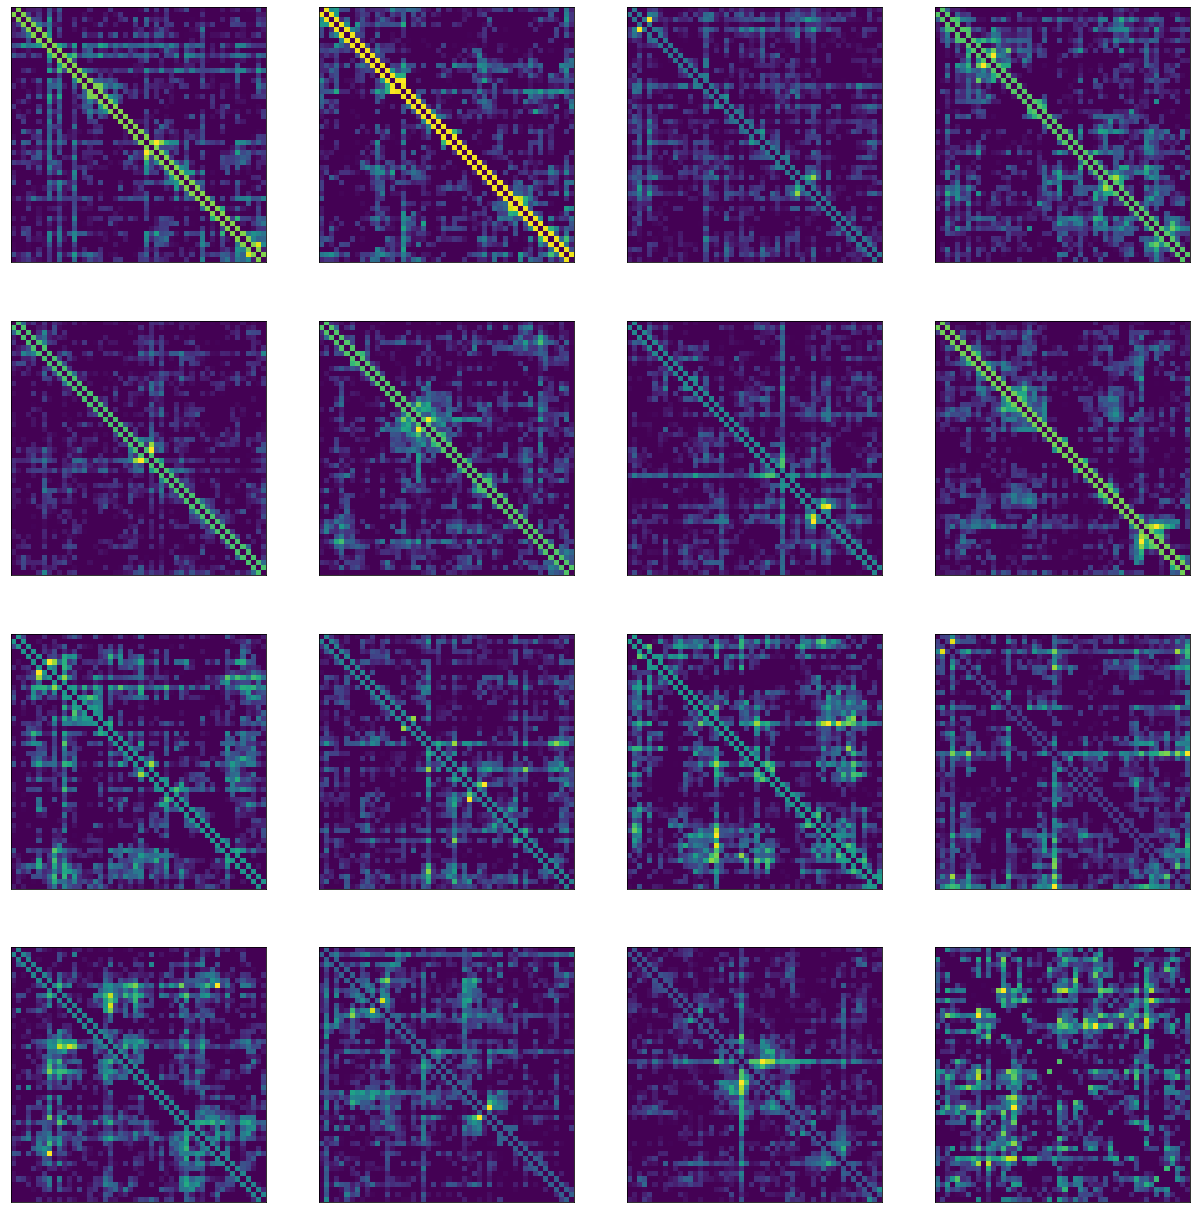

In [22]:
W = results_dict_new.get('loading')[0]
display_dictionary(save_name=save_folder+'Caltech_LMF_Dictionaries', W=W, figsize=[20,20])